# Movie Rating Prediction Model

## Khám phá dữ liệu phục vụ cho việc tiền xử lý

### Import các thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

### Load vào dữ liệu thô sau khi đã được crawl

In [2]:
file_path = "../data/raw/IMDB_movies_final.csv"
df = pd.read_csv(file_path)

### Thông tin cơ bản

Dữ liệu sau khi load được lưu vào biến `df`. Để có cái nhìn bao quát về cấu trúc và đặc điểm của dataset, nhóm hiển thị 5 dòng đầu và 5 dòng cuối của dữ liệu như sau 

In [3]:
# Hiển thị 5 dòng đầu
df.head()

,rank,title,genres,budget,release_year,run_time,mpa,metascore,vote_count,rating
0,1,Frankenstein,"Drama, Fantasy, Horror, Sci-Fi","$120,000,000 (estimated)",2025.0,2h 29m,R,77.0,(132K),7.6
1,2,One Battle After Another,"Action, Crime, Drama, Thriller","$130,000,000 (estimated)",2025.0,2h 41m,R,95.0,(163K),8.0
2,3,The Running Man,"Action, Adventure, Sci-Fi, Thriller","$110,000,000 (estimated)",2025.0,2h 13m,R,56.0,(17K),6.7
3,4,Predator: Badlands,"Action, Adventure, Sci-Fi, Thriller","$105,000,000 (estimated)",2025.0,1h 47m,PG-13,71.0,(38K),7.5
4,5,Playdate,"Action, Comedy","$17,525",2025.0,1h 33m,PG-13,20.0,(10K),5.5


In [4]:
# Hiển thị 5 dòng cuối
df.tail()

,rank,title,genres,budget,release_year,run_time,mpa,metascore,vote_count,rating
10043,10046,Return of the Living Dead III,Horror,"$2,000,000 (estimated)",1993.0,1h 37m,NaN,47.0,(18K),5.9
10044,10047,Sweetness,Thriller,NaN,2025.0,1h 33m,NaN,NaN,(81),6.8
10045,10048,Dark Harvest,"Fantasy, Horror",NaN,2023.0,1h 36m,R,51.0,(10K),5.5
10046,10049,Across the River and Into the Trees,"Drama, Romance, War",NaN,2022.0,1h 46m,NaN,63.0,(1K),6.6
10047,10050,Below,"Action, Horror, Mystery, Thriller","$40,000,000 (estimated)",2002.0,1h 45m,R,55.0,(26K),6.1


Và số dòng, số cột của dataset

In [5]:
num_rows, num_columns = df.shape
print(f"Số dòng: {num_rows}")
print(f"Số cột: {num_columns}")

Số dòng: 10048
Số cột: 10


Dữ liệu bao gồm 10048 số lượng record và 10 đặc trưng, ý nghĩa của mỗi dòng dữ liệu phản ánh các thông tin chi tiết cho mỗi bộ phim trên nền tảng IMDb qua các đặc điểm như là xếp hạng phim, tiêu đề, thể loại, kinh phí, năm phát hành, thời lượng bộ phim, MPA, điểm metascore, số lượng bình chọn và điểm rating. 

Kích thước của bộ dữ liệu có độ lớn tương đối, có ý nghĩa đối với các phân tích xu hướng, và mô hình hóa dự đoán cho điểm rating. 

### Tính toàn vẹn dữ liệu (Data integrity)

Để kiểm tra bộ dataset có bị trùng lặp (duplicated) hay không, nhóm sử dụng phương thức `duplicated()` trong `Pandas` để phát hiện các dòng trùng lặp.

In [6]:
duplicate_rows = df[df.duplicated()]
num_duplicates = df.duplicated().sum()

print(f"Số lượng dòng trùng lặp hoàn toàn: {num_duplicates}")

if num_duplicates > 0:
    print("Các dòng trùng lặp:")
    print(duplicate_rows)

Số lượng dòng trùng lặp hoàn toàn: 0


Nhóm còn kiểm tra có dòng nào trong bộ dataset mà không chứa bất kỳ thông tin nào hay không qua phương thức `isnull()` trong `Pandas`. 

In [7]:
empty_rows_count = df.isnull().all(axis=1).sum()

if empty_rows_count > 0:
    print(f"Có {empty_rows_count} dòng hoàn toàn trống")
else:
    print("Tất cả các dòng đều có ít nhất một dữ liệu (không có dòng không chứa bất kỳ thông tin nào)")

Tất cả các dòng đều có ít nhất một dữ liệu (không có dòng không chứa bất kỳ thông tin nào)


Nhóm kết luận bộ dataset đảm bảo được tính toàn vẹn về dữ liệu.

### Tính chính xác dữ liệu (Data validation)

Nhóm tiến hành kiểm tra xem giá trị của các cột dữ liệu nào có bất hợp lý hay không, cụ thể như sau: 

- Điểm `rating` phải nằm trong đoạn từ 0 đến 10. 

In [8]:
invalid_rating = df[(df['rating'] < 0) | (df['rating'] > 10)]
if len(invalid_rating) > 0:
    print(f"Có {len(invalid_rating)} dòng có điểm rating bất hợp lý (ngoài 0-10), gồm:")
    print(invalid_rating[['title', 'rating']])
else:
    print("Giá trị của đặc trưng rating hợp lệ")

Giá trị của đặc trưng rating hợp lệ


- Điểm `metascore` phải nằm trong đoạn từ 0 đến 100.

In [9]:
invalid_metascore = df[(df['metascore'] < 0) | (df['metascore'] > 100)]
if len(invalid_metascore) > 0:
    print(f"Có {len(invalid_metascore)} dòng có điểm metascore bất hợp lý (ngoài 0-100), gồm:")
    print(invalid_metascore[['title', 'metascore']])
else:
    print("Giá trị của đặc trưng metascore hợp lệ")

Giá trị của đặc trưng metascore hợp lệ


- Thời lượng (`run_time`) bộ phim phải lớn hơn 0. 

In [10]:
def parse_runtime(runtime_str):
        if pd.isna(runtime_str): 
            return None
            
        # Tìm giờ và phút
        h_match = re.search(r'(\d+)h', str(runtime_str))
        m_match = re.search(r'(\d+)m', str(runtime_str))

        if h_match:
            hours = int(h_match.group(1))  
        else:
            hours = 0

        if m_match: 
            minutes = int(m_match.group(1))
        else:
            minutes = 0
        
        total_minutes = hours * 60 + minutes
        return total_minutes

duration_minutes = df['run_time'].apply(parse_runtime)

invalid_runtime = df[duration_minutes <= 0]
if len(invalid_runtime) > 0:
    print(f"Có {len(invalid_runtime)} phim có thời lượng bất hợp lý (<= 0), gồm: ")
    print(invalid_runtime[['title', 'run_time']])
else:
    print("Giá trị của đặc trưng thời lượng (run_time) hợp lệ (lớn hơn 0 phút)")

Giá trị của đặc trưng thời lượng (run_time) hợp lệ (lớn hơn 0 phút)


### Đánh giá trên từng đặc trưng

In [11]:
df.keys()

Index(['rank', 'title', 'genres', 'budget', 'release_year', 'run_time', 'mpa',
       'metascore', 'vote_count', 'rating'],
      dtype='object')

Ý nghĩa của mỗi đặc trưng như sau: 
- `rank`: Thứ hạng của bộ phim trong danh sách các bộ phim được crawl về và cũng là số thứ tự được gán tại thời điểm crawl. 
- `title`: Tên chính thức của bộ phim.
- `genres`: Các thể loại của phim (một phim có thể thuộc nhiều thể loại, ngăn cách nhau bởi dấu phẩy).
- `budget`: Kinh phí sản xuất bộ phim (bao gồm cả đơn vị tiền tệ và đôi khi có ghi chú "estimated").
- `release_year`: Năm bộ phim được công chiếu lần đầu.
- `run_time`: Thời lượng của bộ phim (thường ở định dạng chuỗi gồm có giờ và phút).
- `mpa`: Phân loại độ tuổi khán giả tiếp cận bộ phim (theo chuẩn MPAA của Mỹ).
- `metascore`: Điểm số đánh giá từ các nhà phê bình chuyên nghiệp (trên thang 100).
- `vote_count`: Số lượng khán giả đã tham gia bình chọn trên IMDb.
- `rating`: Điểm số trung bình do khán giả trên nền tảng IMDb đánh giá (trên thang 10).

Các đặc trưng `title`, `genres`, `mpa`, `rank` thuộc loại định tính (qualitative), trong đó `title`, `genres` thuộc nhóm định danh (nominal) còn `mpa` và `rank` thuộc nhóm thứ bậc (ordinal).

Các đặc trưng còn lại thuộc loại định lượng (quantitative), trong đó `mpa` và `rank` có tính chất rời rạc (discrete) còn `rating`, `metascore`, `vote_count` và `run_time` có tính chất liên tục (continuous).

Hầu hết các đặc trưng trong dataset này đều có giá trị tiềm năng cao cho việc phân tích và xây dựng mô hình học máy từ dữ liệu phim, cụ thể như sau:
- `title` dùng để định danh các bộ phim nào.
- `genres` và `mpa` dùng để phân tích xu hướng theo thể loại và độ tuổi.
- `metascore` có thể dùng để  so sánh giữa đánh giá của khán giả (rating) và chuyên gia (metascore).
- `vote_count` dùng để đo lường độ phổ biến của phim.
- `budget` dùng để phân tích mối tương quan giữa số tiền đầu tư vào để sản xuất và chất lượng của phim.
- `run_time` dùng để phân tích xem liệu thời lượng phim dài hay ngắn thì sẽ được ưa chuộng hơn.
- `release_year` dùng để phân tích xu hướng qua các năm.
- Cuối cùng là `rating` là đặc trưng quan trọng nhất để đánh giá chất lượng phim.

Có thể thấy đặc trưng `rank` nên được bỏ ra cho quá trình phân tích và xây dựng mô hình dự đoán của phim về sau. Lí do là vì:  
- Không mang tính đại diện và có thể gây nhiễu: Giá trị của `rank` này chỉ là số thứ tự trong danh sách lúc crawl dữ liệu, nó có thể biến động liên tục và không phản ánh chất lượng chính xác về lâu dài của bộ phim. Nếu đưa vào mô hình máy học để dự đoán, giá trị của `rank` có thể gây hiểu nhầm cho mô hình rằng giá trị của càng nhỏ thì `rating` của bộ phim càng tốt, làm cho chất lượng mô hình giảm xuống. 
- Dư thừa: Vì `rank` mang ý nghĩa là index nhiều hơn là một đặc trưng của bộ phim.

### Kiểu dữ liệu cho mỗi đặc trưng

In [12]:
df.dtypes

rank              int64
title            object
genres           object
budget           object
release_year    float64
run_time         object
mpa              object
metascore       float64
vote_count       object
rating          float64
dtype: object

Kiểu dữ liệu hiện tại cho các đặc trưng như sau: 
- `rank` mang kiểu `int64`.
- `release_year`, `metascore` và `rating` mang kiểu `float64`.
- `title`, `genres`, `budget`, `run_time`, `mpa`, `vote_count` mang kiểu `object`. 

Có một số đặc trưng hiện tại mang kiểu dữ liệu không phù hợp không, và cần nên chuyển đổi thành kiểu dữ liệu khác cho phù hợp kết hợp với 1 số kỹ thuật tiền xử lý.  

- `run_time` hiện tại mang kiểu `object` vì chứa cả số giờ và số phút. Vì vậy nhóm quyết định tách giá trị chỉ số giờ và phút ra bằng cách tìm trên chuỗi thông qua phương thức `re.search`, quy đổi tất cả về phút và chuyển sang kiểu `int`.

In [13]:
def parse_runtime(runtime_str):
        if pd.isna(runtime_str): 
            return None
            
        # Tìm giờ và phút
        h_match = re.search(r'(\d+)h', str(runtime_str))
        m_match = re.search(r'(\d+)m', str(runtime_str))

        if h_match:
            hours = int(h_match.group(1))  
        else:
            hours = 0

        if m_match: 
            minutes = int(m_match.group(1))
        else:
            minutes = 0
        
        total_minutes = hours * 60 + minutes
        return total_minutes

In [14]:
df['run_time'] = df['run_time'].apply(parse_runtime)

- `vote_count` hiện tại mang kiểu `object` do chứa ngoặc đơn () và hậu tố viết tắt như K (ngàn), M (triệu). Vì vậy cần xử lý các hậu tố  này bằng cách nếu là K thì nhân thêm cho 1000, M thì nhân thêm cho 1.000.000 và chuyển sang kiểu `int`. 

In [15]:
def parse_votes(val):
    if pd.isna(val): 
        return None
    
    val = str(val).replace('(', '').replace(')', '').replace(',', '').replace('-', '')
    
    if not val.strip():
        return None

    multiplier = 1
    val_lower = val.lower()
    
    if 'k' in val_lower:
        multiplier = 1000
        val = val_lower.replace('k', '')
    elif 'm' in val_lower:
        multiplier = 1000000
        val = val_lower.replace('m', '')
        
    try:
        return int(float(val) * multiplier)
    except:
        return None

In [16]:
df['vote_count'] = df['vote_count'].apply(parse_votes)

In [17]:
def clean_and_convert_budget(val):
    if pd.isna(val):
        return np.nan
    
    val_str = str(val)
    
    rate = 1.0 
    
    if '€' in val_str or 'EUR' in val_str:
        rate = 1.1   # Euro (~1.1 USD)
    elif '£' in val_str or 'GBP' in val_str:
        rate = 1.25  # Bảng Anh (~1.25 USD)
    elif '¥' in val_str or 'JPY' in val_str:
        rate = 0.0075 # Yên Nhật (~130-140 JPY = 1 USD)
    elif '₹' in val_str or 'INR' in val_str:
        rate = 0.012 # Rupee Ấn Độ
    elif 'CAD' in val_str:
        rate = 0.75  # Đô la Canada
    elif 'AUD' in val_str:
        rate = 0.65  # Đô la Úc
    elif 'KRW' in val_str or '₩' in val_str:
        rate = 0.00075 # Won Hàn Quốc
    elif 'ITL' in val_str:
        rate = 0.00060 # Tiền Italia

    clean_num_str = re.sub(r'[^\d.]', '', val_str)
    
    try:
        if not clean_num_str: return np.nan
        amount = float(clean_num_str)
        return amount * rate
    except ValueError:
        return np.nan

In [18]:
df['budget'] = df['budget'].apply(clean_and_convert_budget)

In [19]:
df.head()

,rank,title,genres,budget,release_year,run_time,mpa,metascore,vote_count,rating
0,1,Frankenstein,"Drama, Fantasy, Horror, Sci-Fi",120000000.0,2025.0,149.0,R,77.0,132000.0,7.6
1,2,One Battle After Another,"Action, Crime, Drama, Thriller",130000000.0,2025.0,161.0,R,95.0,163000.0,8.0
2,3,The Running Man,"Action, Adventure, Sci-Fi, Thriller",110000000.0,2025.0,133.0,R,56.0,17000.0,6.7
3,4,Predator: Badlands,"Action, Adventure, Sci-Fi, Thriller",105000000.0,2025.0,107.0,PG-13,71.0,38000.0,7.5
4,5,Playdate,"Action, Comedy",17525.0,2025.0,93.0,PG-13,20.0,10000.0,5.5


### Phân tích trên các cột dữ liệu thuộc loại numerical

- Các cột numerical

In [20]:
numerical_cols = [  'budget',
                    'run_time',
                    'metascore',
                    'vote_count',
                    'rating'    ]

- Visualization histogram và box để kiểm tra xem sự phân bố dử liệu và các outlier

In [21]:
def plots(col):
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    sns.histplot(df[col], bins=20, kde=True, ax=axes[0])
    axes[0].set_title(f"Histogram - {col}")

    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot - {col}")

    plt.tight_layout()
    plt.show()

- Hàm kiểm tra dữ liệu của cột `col` lệch trái, phải hay bình thường

In [22]:
def distribution_shape(col):
    skew = df[col].skew()

    if np.around(skew) == 0:
        return 'Normal'
    elif skew < 0:
        return 'Left'
    else:
        return 'Right'

- Hàm phân tích dữ liệu cột `col`:
    - In ra `Distribution shape`.
    - Dùng hàm `describe` trong `df` để in ra `count` , `mean` ,... .
    - Sau đó kiểm tra các giá trị `min`, `max` có `reasonable` hay không?
        - min > Q1 - 1.5*IQR => reasonable và ngược lại.
        - max < Q3 + 1.5*IQR => reasonable và ngược lại.
    - Find các value outlier trong col và gán nhãn cho nó, có 2 loại label:
        - `Data entry error`: nếu < 0
        - `Extreme value`: nếu giá trị xuất hiện trong `PLACEHOLDERS = [0, -1, 999]`
    - In ra phần trăm missing trong col.
    - In ra các `Invalid values`.
    - In ra các giá trị trong `PLACEHOLDERS = [0, -1, 999]`

In [23]:
def numerical_columns_analysis(col):
    print("="*60)
    print(f"ANALYSIS FOR COLUMN: {col}")
    print("="*60)
    
    distri = distribution_shape(col);
    print("Distribution shape: ", distri);

    info = df[col].describe().apply(lambda x: f"{x:,.0f}")
    print(info);

    min_value = df[col].min()
    max_value = df[col].max()

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    if min_value < lower_bound:
        print("Min value is unreasonable")
    else:
        print("Min value is reasonable")

    if max_value > upper_bound:
        print("Max value is unreasonable")
    else:
        print("Max value is reasonable")

    outliers = df[col][(df[col] < lower_bound) | (df[col] > upper_bound)]

    PLACEHOLDERS = [0, -1, 999]

    labels = np.where((outliers < 0) | (outliers.isin(PLACEHOLDERS)),
                    'Data entry error', 'Extreme value')

    outliers_df = pd.DataFrame({'Value': outliers, 'Label': labels})
    print(outliers_df);


    invalid_values = df[col][df[col] < 0]
    print("Invalid values:", invalid_values)

    placeholder_values = df[col][df[col].isin(PLACEHOLDERS)]
    print("Placeholder values:", placeholder_values)

- Duyệt từng `numerical_cols`:
    - Gọi hàm `numerical_columns_analysis` để thống kê.
    - Sau đó, thực hiện plot để xem sự phân bố của dữ liệu.

ANALYSIS FOR COLUMN: budget
Distribution shape:  Right
count            6,644
mean        35,449,534
std         57,764,311
min                  1
25%          5,000,000
50%         18,000,000
75%         43,000,000
max      2,000,000,000
Name: budget, dtype: object
Min value is reasonable
Max value is unreasonable
            Value          Label
0     120000000.0  Extreme value
1     130000000.0  Extreme value
2     110000000.0  Extreme value
3     105000000.0  Extreme value
9     200000000.0  Extreme value
...           ...            ...
9528  918735880.0  Extreme value
9676  113000000.0  Extreme value
9720  137000000.0  Extreme value
9883  760000000.0  Extreme value
9997  274620000.0  Extreme value

[520 rows x 2 columns]
Invalid values: Series([], Name: budget, dtype: float64)
Placeholder values: Series([], Name: budget, dtype: float64)


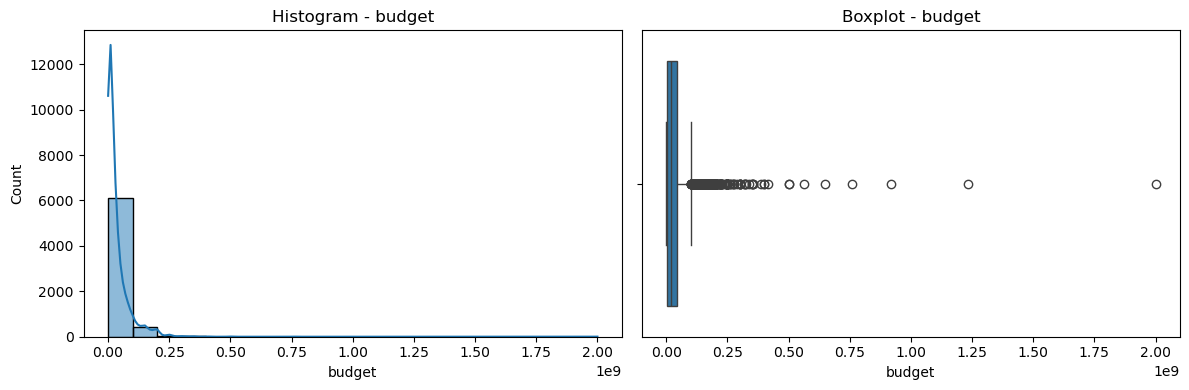

ANALYSIS FOR COLUMN: run_time
Distribution shape:  Right
count    9,668
mean       110
std         23
min         44
25%         95
50%        106
75%        120
max        566
Name: run_time, dtype: object
Min value is unreasonable
Max value is unreasonable
       Value          Label
1      161.0  Extreme value
19     160.0  Extreme value
60     165.0  Extreme value
69     175.0  Extreme value
70     169.0  Extreme value
...      ...            ...
9882   164.0  Extreme value
9931   162.0  Extreme value
9971   170.0  Extreme value
10007   55.0  Extreme value
10022  173.0  Extreme value

[345 rows x 2 columns]
Invalid values: Series([], Name: run_time, dtype: float64)
Placeholder values: Series([], Name: run_time, dtype: float64)


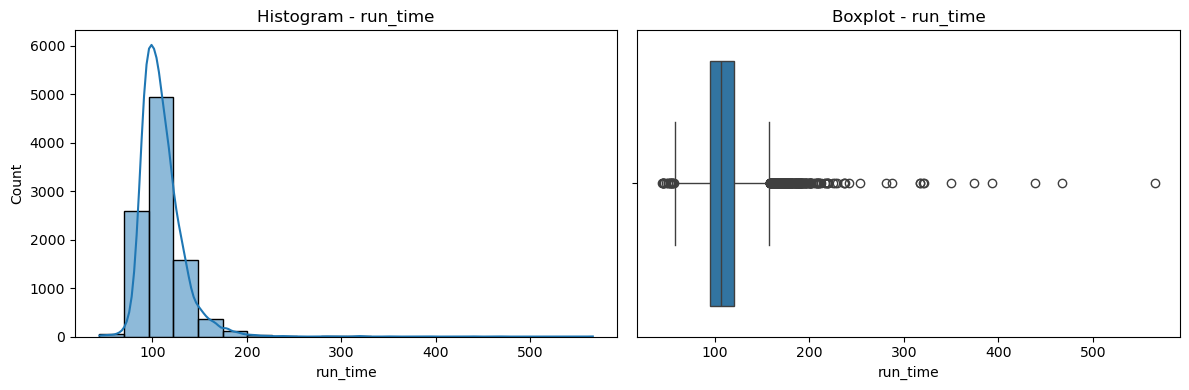

ANALYSIS FOR COLUMN: metascore
Distribution shape:  Normal
count    7,638
mean        60
std         17
min          1
25%         48
50%         61
75%         73
max        100
Name: metascore, dtype: object
Min value is unreasonable
Max value is reasonable
      Value          Label
1342    6.0  Extreme value
3686    9.0  Extreme value
3821    9.0  Extreme value
5615    9.0  Extreme value
8003    9.0  Extreme value
8219    5.0  Extreme value
8807   10.0  Extreme value
9901    1.0  Extreme value
Invalid values: Series([], Name: metascore, dtype: float64)
Placeholder values: Series([], Name: metascore, dtype: float64)


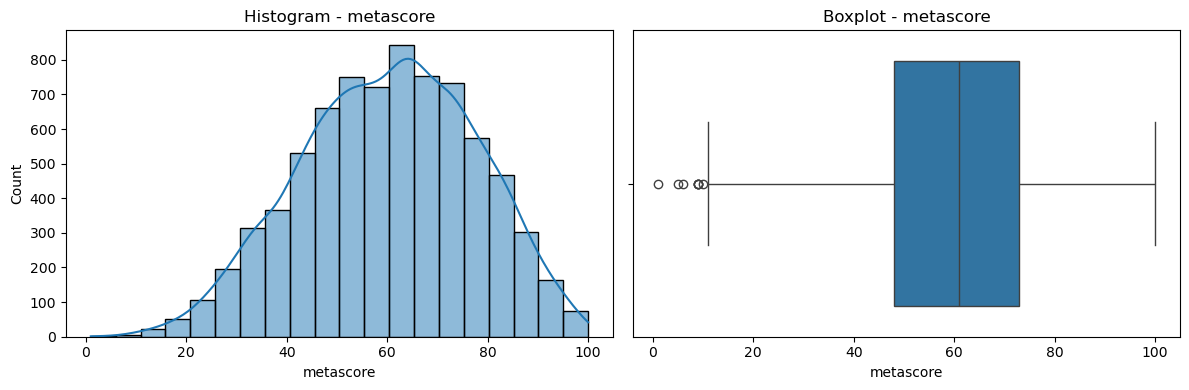

ANALYSIS FOR COLUMN: vote_count
Distribution shape:  Right
count        9,636
mean       104,965
std        194,809
min              6
25%         14,000
50%         42,000
75%        110,000
max      3,100,000
Name: vote_count, dtype: object
Min value is reasonable
Max value is unreasonable
          Value          Label
32     755000.0  Extreme value
35     351000.0  Extreme value
38     314000.0  Extreme value
45    3100000.0  Extreme value
46     350000.0  Extreme value
...         ...            ...
4707   334000.0  Extreme value
4764   269000.0  Extreme value
4945   313000.0  Extreme value
4961   306000.0  Extreme value
5831   578000.0  Extreme value

[971 rows x 2 columns]
Invalid values: Series([], Name: vote_count, dtype: float64)
Placeholder values: Series([], Name: vote_count, dtype: float64)


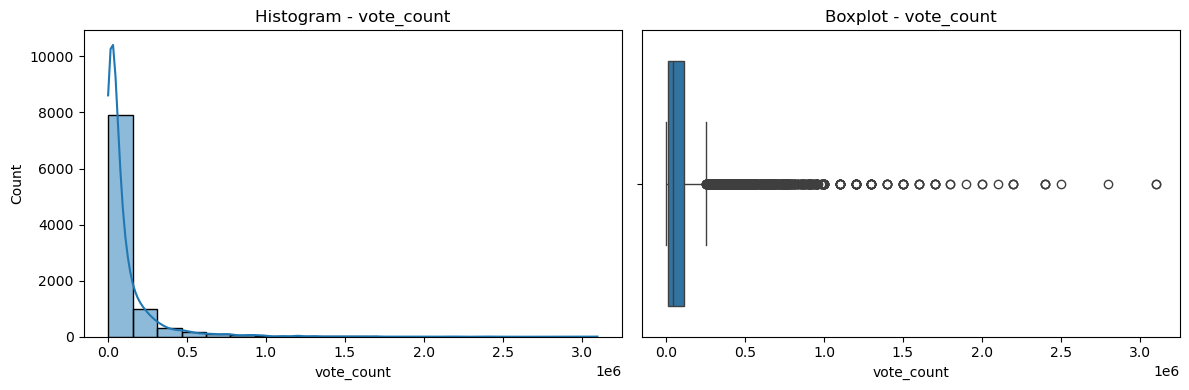

ANALYSIS FOR COLUMN: rating
Distribution shape:  Left
count    9,636
mean         7
std          1
min          2
25%          6
50%          7
75%          7
max         10
Name: rating, dtype: object
Min value is unreasonable
Max value is unreasonable
       Value          Label
45       9.3  Extreme value
69       9.2  Extreme value
74       3.9  Extreme value
209      4.2  Extreme value
324      4.1  Extreme value
...      ...            ...
9954     3.5  Extreme value
10000    4.2  Extreme value
10003    4.0  Extreme value
10030    3.2  Extreme value
10042    3.1  Extreme value

[162 rows x 2 columns]
Invalid values: Series([], Name: rating, dtype: float64)
Placeholder values: Series([], Name: rating, dtype: float64)


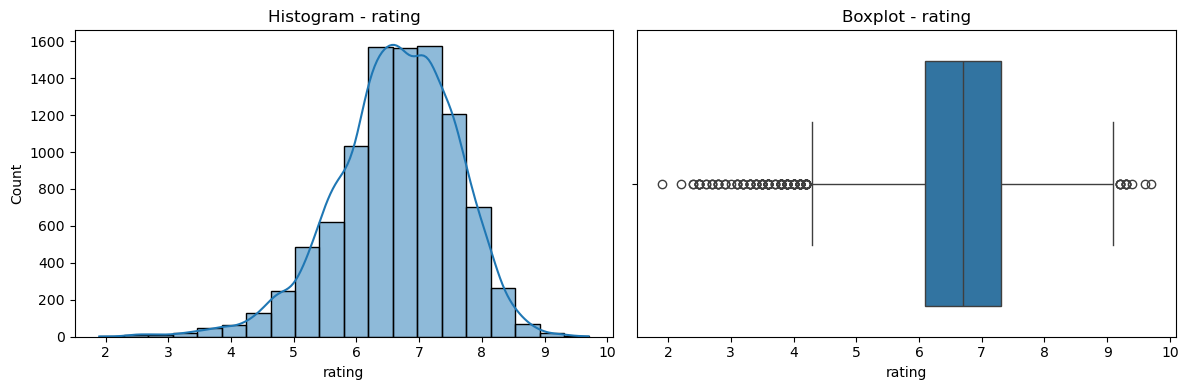

In [24]:
for col in numerical_cols:
    numerical_columns_analysis(col);
    plots(col);

- Tính ma trận tương quan giữa các cột số (numerical columns)

In [25]:
corr = df[numerical_cols].corr()
corr

,budget,run_time,metascore,vote_count,rating
budget,1.000000,0.185894,-0.139082,0.295571,-0.059516
run_time,0.185894,1.000000,0.203683,0.212408,0.326222
metascore,-0.139082,0.203683,1.000000,0.176150,0.711184
vote_count,0.295571,0.212408,0.176150,1.000000,0.311486
rating,-0.059516,0.326222,0.711184,0.311486,1.000000


- Vẽ heatmap ma trận tương quan của các cột số
- Cột nào có **tương quan mạnh** → gần 1 hoặc -1.
- Cột nào **không tương quan** → gần 0.

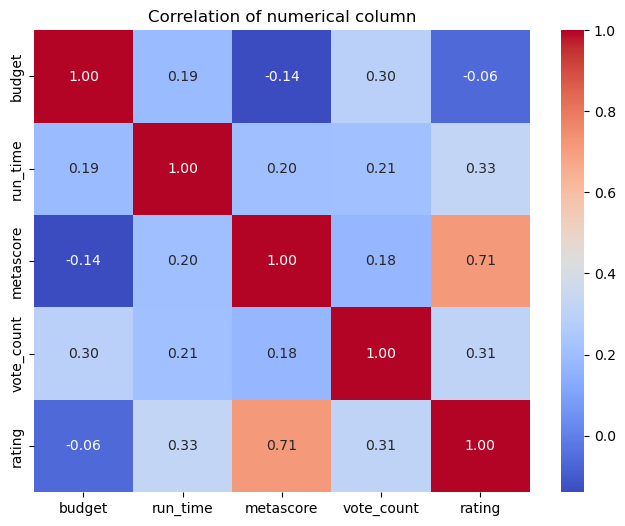

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation of numerical column")
plt.show()

- Dựa vào visualization về mối tương quan giữa các cột số trên:
  + Hầu như các cột số không có quá nhiều tương quan với nhau, điều này cho thấy nhiều đặc trưng mang tính độc lập, ví dụ như: budget.
  + Ngoài ra, ta có thể thấy được mối tương quan mạnh mẽ giữa cột `metascore` và `rating`, điều này cho thấy điểm đánh giá của chuyên gia có ảnh hưởng lớn đến điểm đánh giá của khán giả.

- Vẽ pairplot (scatter plot cho tất cả các cặp cột số)
- Mục đích:
    + Phát hiện outliers hoặc clusters tiềm năng trong dữ liệu.
    + Quan sát tương quan, xu hướng tuyến tính hoặc phi tuyến giữa các cột số.

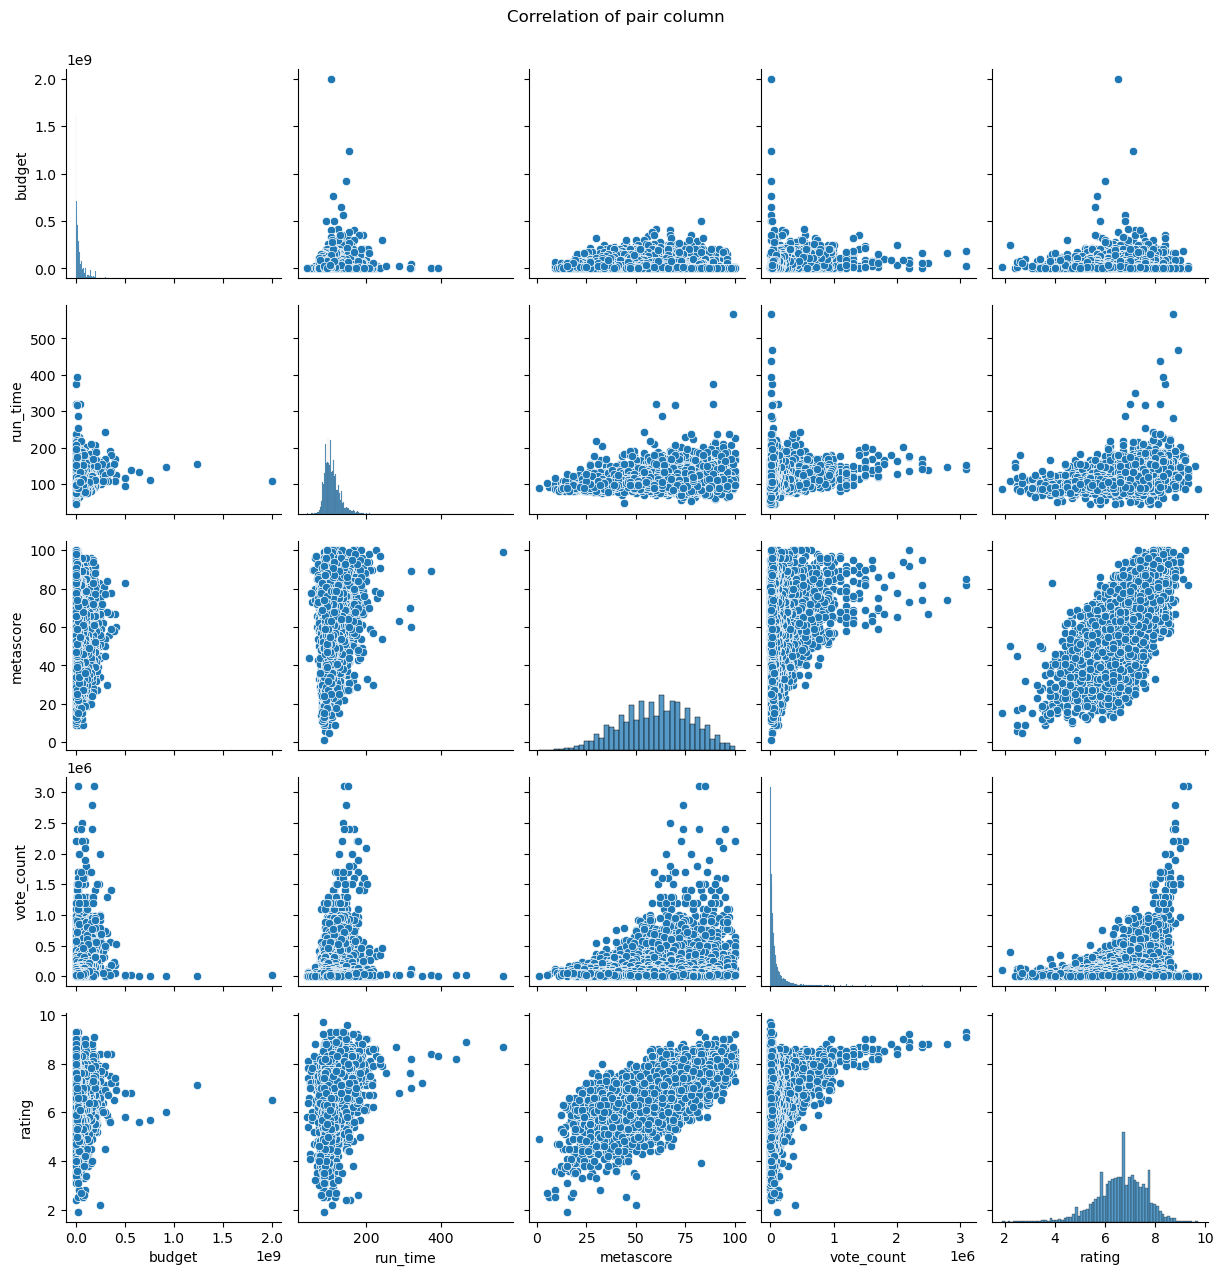

In [27]:

sns.pairplot(df[numerical_cols])
plt.suptitle('Correlation of pair column', y=1.02)  
plt.show()

- Dựa vào visualization về tương quan giữa các cặp cột số trên:

- Cột `metascore` và `rating`: 
  + Có sự **tương quan dương (Positive Correlation)** rõ rệt. Khi điểm đánh giá của chuyên gia (`metascore`) tăng thì điểm của khán giả (`rating`) cũng có xu hướng tăng.

- Cột `vote_count` và `rating`:
  + Tạo thành hình phễu. Các phim có lượng vote cao thường có `rating` ổn định ở mức khá trở lên (> 6.0). Phim dở thường ít người quan tâm bình chọn.

- Cột `run_time` và `rating`:
  + Các bộ phim có thời lượng nhiều hơn 200 phút thường có `rating` cao hơn 7.0, cho thấy xu hướng người xem ưa chuộng các bộ phim dài hơn. 

### Phân tích trên các cột dữ liệu thuộc loại categorical

- Lấy danh sách các cột categorical mặc định

In [28]:
category_cols = ['genres', 'mpa']

- Xử lý đặc biệt cho cột 'genres' (Preprocessing)
    Vì cột thể loại phim thường chứa nhiều giá trị trong một ô (ví dụ: *"Action, Adventure, Sci-Fi"*), nên không thể đếm trực tiếp. Code xử lý như sau:
    - `df[col].str.split(', ')`: Cắt chuỗi ban đầu thành một danh sách (List) các thể loại.
    - `df.explode('genres_list')`: Kỹ thuật "bùng nổ" dữ liệu. Nó tách một dòng chứa list 3 phần tử thành 3 dòng riêng biệt.
        - Ví dụ: Dòng phim A có thể loại `[Action, Comedy]` sẽ tách thành 2 dòng: một dòng là `Action`, một dòng là `Comedy`.
        - Mục đích: Giúp hàm `value_counts()` đếm chính xác số lượng phim thuộc từng thể loại riêng lẻ.

- Thống kê cơ bản (Basic Statistics)
  - `unique()`: Liệt kê tên các danh mục đang có (ví dụ: Action, Drama, Horror...).
  - `nunique()`: Đếm tổng số lượng danh mục (ví dụ: có tất cả 18 thể loại phim).
  - `value_counts().head(10)`: Đếm số lần xuất hiện và chỉ lấy 10 danh mục phổ biến nhất để tránh làm rối màn hình.
  - `normalize=True`: Chuyển đổi từ số lượng đếm sang tỷ lệ phần trăm (0-100%) để dễ so sánh.
- Thuật toán kiểm tra mất cân bằng (Imbalance Check)
    Code tự động đánh giá độ lệch của dữ liệu dựa trên tỷ lệ của nhóm đa số (`max_ratio`):
    - Nếu > 80%: Dữ liệu bị lệch nghiêm trọng (Highly imbalanced). Mô hình học máy có thể bị thiên kiến, chỉ dự đoán ra nhóm đa số này.
    - Nếu > 50%: Có sự chênh lệch đáng kể (Some imbalance), cần lưu ý khi chia tập train/test.
    - Còn lại: Dữ liệu phân phối khá đồng đều (Fairly balanced).

- Kiểm tra chất lượng dữ liệu (Data Quality)
  - Missing values: Tính tỷ lệ phần trăm ô trống (NaN).
  - Rare categories: Lọc ra các danh mục xuất hiện dưới 5 lần.

- Trực quan hóa (Visualization)
  - Sử dụng biểu đồ thanh ngang `barh` để hiển thị Top 10.
  - Hàm `ax.bar_label`: Tự động điền con số cụ thể vào đầu mỗi thanh biểu đồ giúp người xem không cần gióng mắt xuống trục hoành để ước lượng.

In [ ]:
def category_analysis(col):
    if col == 'genres':
        # Split để tạo list
        df['genres_list'] = df[col].str.split(', ')
        # Explode nhưng KHÔNG ghi đè df gốc
        temp = df.explode('genres_list')
        col_to_analyze = 'genres_list'
    else:
        temp = df.copy()
        col_to_analyze = col

    print("="*60)
    print(f"ANALYSIS FOR COLUMN: {col}")
    print("="*60)

    # Unique values
    print("\nUnique/distinct values:")
    print(temp[col_to_analyze].unique())
    
    # Number of unique values
    print("\nNumber of unique values:")
    print(temp[col_to_analyze].nunique())

    # Top 10 most frequent
    print("\nTop 10 most frequent values:")
    print(temp[col_to_analyze].value_counts().head(10))

    # Normalized frequency %
    print("\nPercentage distribution:")
    print((temp[col_to_analyze].value_counts(normalize=True) * 100).head(10))

    # Balance check
    print("\nBalance check:")
    dist = temp[col_to_analyze].value_counts(normalize=True) * 100
    max_ratio = dist.iloc[0]

    if max_ratio > 80:
        print("Distribution is **highly imbalanced**.")
    elif max_ratio > 50:
        print("Some imbalance present.")
    else:
        print("Distribution is fairly balanced.")

    freq = temp[col_to_analyze].value_counts()
    rare = freq[freq < 5]     
    print("\nRare categories:")
    print(rare);

    # Visualization
    plt.figure(figsize=(10, 5))
    ax = temp[col_to_analyze].value_counts().head(10).plot(kind='barh')
    ax.bar_label(ax.containers[0], padding=3)
    plt.title(f"\nTop 10 Frequent Values in '{col}'")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.show();

ANALYSIS FOR COLUMN: genres

Unique/distinct values:
['Drama' 'Fantasy' 'Horror' 'Sci-Fi' 'Action' 'Crime' 'Thriller'
 'Adventure' 'Comedy' 'Biography' 'History' 'War' 'Music' 'Romance'
 'Mystery' 'Western' 'Animation' 'Family' 'Musical' 'Sport' nan
 'Documentary' 'Film-Noir' 'News']

Number of unique values:
23

Top 10 most frequent values:
genres_list
Drama        5695
Thriller     3342
Comedy       3169
Action       2304
Romance      2015
Crime        1874
Adventure    1688
Horror       1574
Mystery      1442
Sci-Fi       1225
Name: count, dtype: int64

Percentage distribution:
genres_list
Drama        19.022011
Thriller     11.162697
Comedy       10.584856
Action        7.695648
Romance       6.730352
Crime         6.259394
Adventure     5.638131
Horror        5.257357
Mystery       4.816460
Sci-Fi        4.091653
Name: proportion, dtype: float64

Balance check:
Distribution is fairly balanced.

Rare categories:
genres_list
News    1
Name: count, dtype: int64


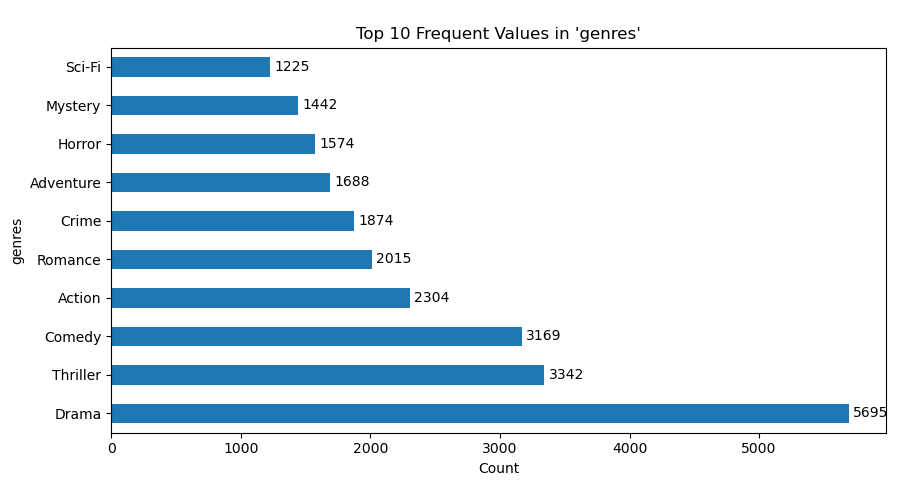

ANALYSIS FOR COLUMN: mpa

Unique/distinct values:
['R' 'PG-13' nan 'PG' 'TV-PG' 'TV-MA' 'Not Rated' 'Approved' 'TV-G' 'G'
 'Unrated' 'NC-17' 'TV-14' '18+' 'M/PG' 'Passed' 'X' '13+' 'GP' '16+' 'M'
 'TV-Y7' 'MA-17' 'TV-Y']

Number of unique values:
23

Top 10 most frequent values:
mpa
R            3763
PG-13        2005
PG           1109
Not Rated     746
Approved      297
TV-MA         256
G             192
Unrated       124
TV-14          89
TV-PG          37
Name: count, dtype: int64

Percentage distribution:
mpa
R            43.173474
PG-13        23.003671
PG           12.723726
Not Rated     8.558972
Approved      3.407526
TV-MA         2.937127
G             2.202845
Unrated       1.422671
TV-14         1.021111
TV-PG         0.424507
Name: proportion, dtype: float64

Balance check:
Distribution is fairly balanced.

Rare categories:
mpa
M/PG     4
X        4
16+      4
TV-Y7    3
MA-17    1
TV-Y     1
Name: count, dtype: int64


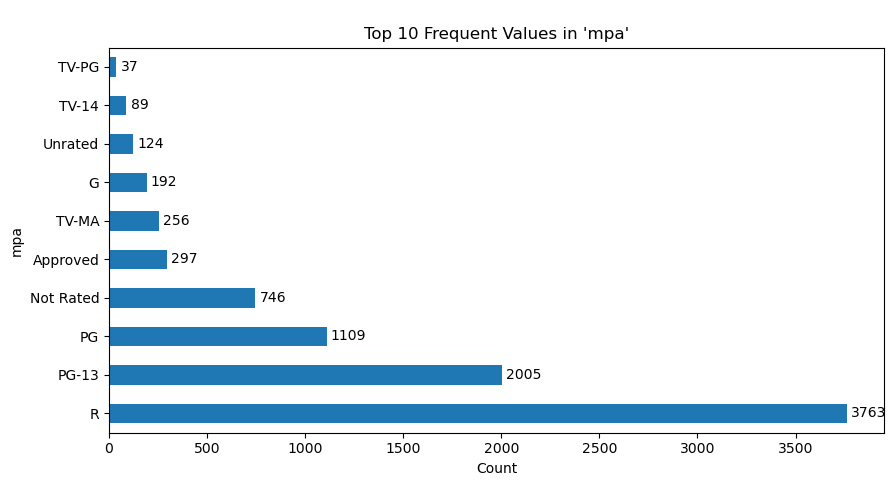

In [30]:
for col in category_cols:
    category_analysis(col);

### Visualize mối quan hệ giữa Genres và MPA

#### 1. Cấu hình
- top_n_genres = 15: Lấy top 15 genres phổ biến
- genre_col = 'genres': cột chứa thể loại phim
- category_col = 'mpa': cột chứa rating phim

#### 2. Copy dataset
- df_exploded = df.copy(): tạo bản sao dataset để không làm thay đổi gốc

#### 3. Tách genres thành list
- df_exploded[genre_col] = df_exploded[genre_col].str.split(', ')
- Nếu 1 phim có nhiều thể loại, tách các thể loại thành list

#### 4. Explode
- df_exploded = df_exploded.explode(genre_col)
- Mỗi thể loại trở thành 1 dòng riêng

#### 5. Lấy top N genres
- top_genres = df_exploded[genre_col].value_counts().head(top_n_genres).index

#### 6. Lọc dataset chỉ chứa top genres
- df_top = df_exploded[df_exploded[genre_col].isin(top_genres)]

#### 7. Tạo cross-tab
- cross_tab = pd.crosstab(df_top[genre_col], df_top[category_col])
- Hàng: genres (top 15)
- Cột: MPA ratings
- Giá trị: số lượng phim thuộc cặp (genre, mpa)

#### Mục đích
- Xem mối quan hệ giữa thể loại phim và rating
- Sử dụng cross-tab để vẽ heatmap hoặc stacked bar chart


In [ ]:
top_n_genres = 15  # Lấy top 15 genres phổ biến
genre_col = 'genres'
category_col = 'mpa'

df_exploded = df.copy()
df_exploded[genre_col] = df_exploded[genre_col].str.split(', ')
df_exploded = df_exploded.explode(genre_col)

top_genres = df_exploded[genre_col].value_counts().head(top_n_genres).index
df_top = df_exploded[df_exploded[genre_col].isin(top_genres)]

cross_tab = pd.crosstab(df_top[genre_col], df_top[category_col])



- Vẽ heatmap số lượng phim theo Genres và MPA
- Mục đích:
  + Nhận biết thể loại nào phổ biến theo từng rating

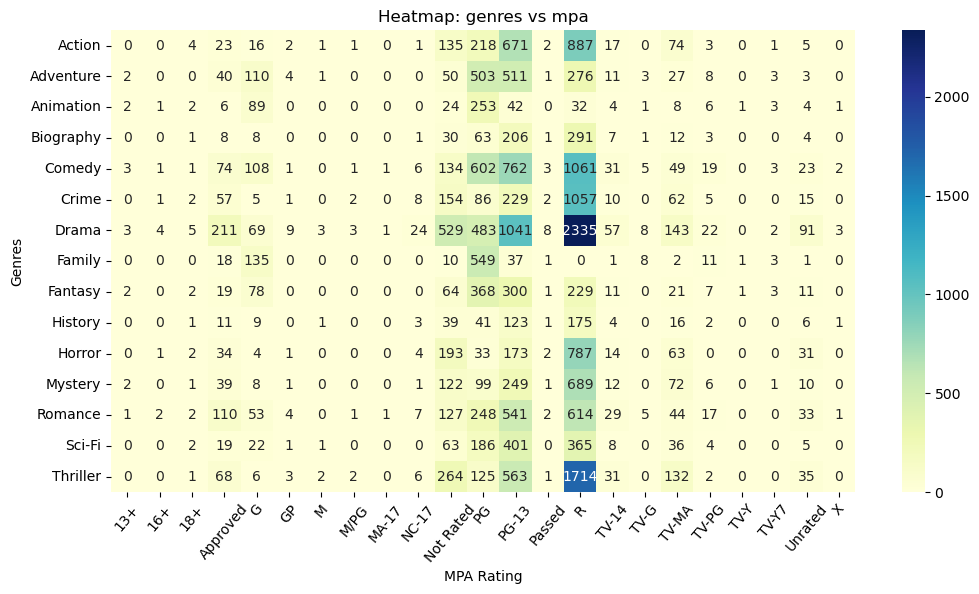

In [32]:
plt.figure(figsize=(12,6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title(f"Heatmap: {genre_col} vs {category_col}")
plt.ylabel("Genres")
plt.xticks(rotation=50)
plt.xlabel("MPA Rating")
plt.show()

- Dựa vào visualization Heatmap trên:
+ Bộ phim với thể loại Drama có số lượng lớn nhất trong các thể loại phim với phân loại MPA là R.
+ Các thể loại phim, hầu hết đều tập trung vào phân loại MPA là R và PG-13, cho thấy xu hướng phổ biến của các thể loại phim này đối với khán giả trưởng thành và thanh thiếu niên. 

- Vẽ stacked bar chart tỷ lệ MPA theo Genres
- Mục đích:
    + Quan sát **tỉ lệ MPA rating trong từng thể loại phim**
    + Nhìn trực quan thể loại nào có rating phổ biến nhất

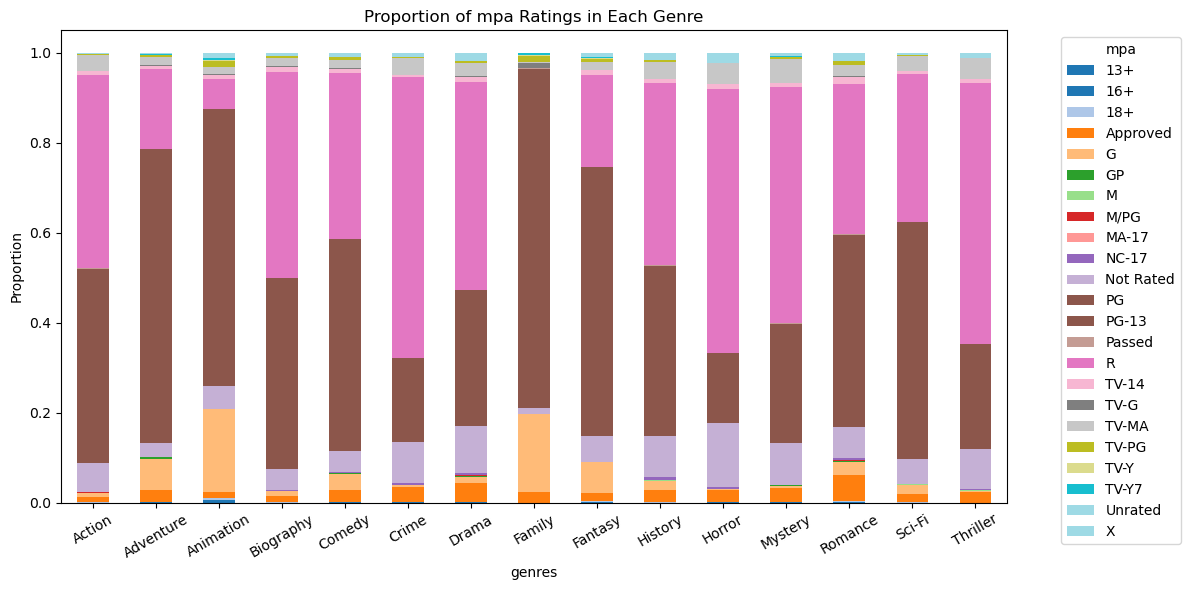

In [33]:
cross_tab_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)  # chuyển sang tỉ lệ
cross_tab_norm.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
plt.ylabel("Proportion")
plt.title(f"Proportion of {category_col} Ratings in Each Genre")
plt.xticks(rotation=30)
plt.legend(title=category_col, bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

- Dựa vào stacked bar chart trên:
+ Hầu như các phân loại PG-13 và R chiếm tỷ lệ lớn, cho thấy xu hướng phát triển phim chủ yếu đánh vào các khán giả này

### Phân tích cho missing values

Nhóm tính toán tỉ lệ các missing values cho mỗi đặc trưng, kết quả như sau

In [34]:
cols_to_check = ['rank', 'title', 'budget', 'metascore', 'mpa', 'vote_count', 'rating', 'run_time', 'release_year', 'genres']
missing_data = df[cols_to_check].isnull().sum()
missing_percent = (df[cols_to_check].isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({'Missing Count': missing_data, 'Percentage (%)': missing_percent})
missing_df = missing_df[missing_df['Missing Count'] >= 0].sort_values(by='Percentage (%)', ascending=False)

print(missing_df)

              Missing Count  Percentage (%)
budget                 3404       33.877389
metascore              2410       23.984873
mpa                    1332       13.256369
vote_count              412        4.100318
rating                  412        4.100318
run_time                380        3.781847
release_year            168        1.671975
genres                  133        1.323646
rank                      0        0.000000
title                     0        0.000000


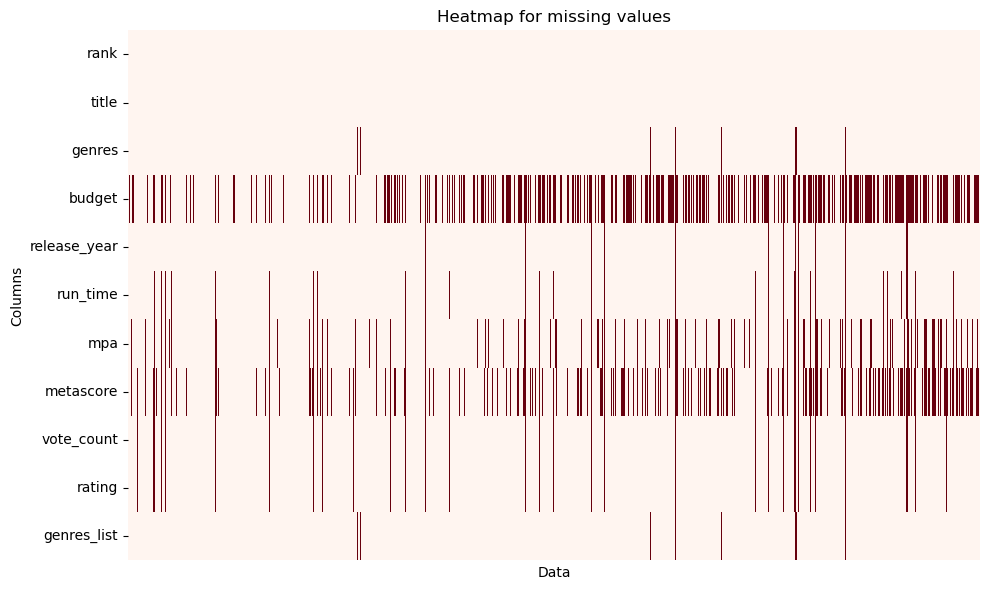

In [35]:
plt.figure(figsize=(10, 6))

sns.heatmap(
    df.isnull().T,
    cbar=False,
    xticklabels=False,
    cmap='Reds'  
)

plt.title('Heatmap for missing values')
plt.xlabel('Data')
plt.ylabel('Columns')

plt.tight_layout()
plt.show()

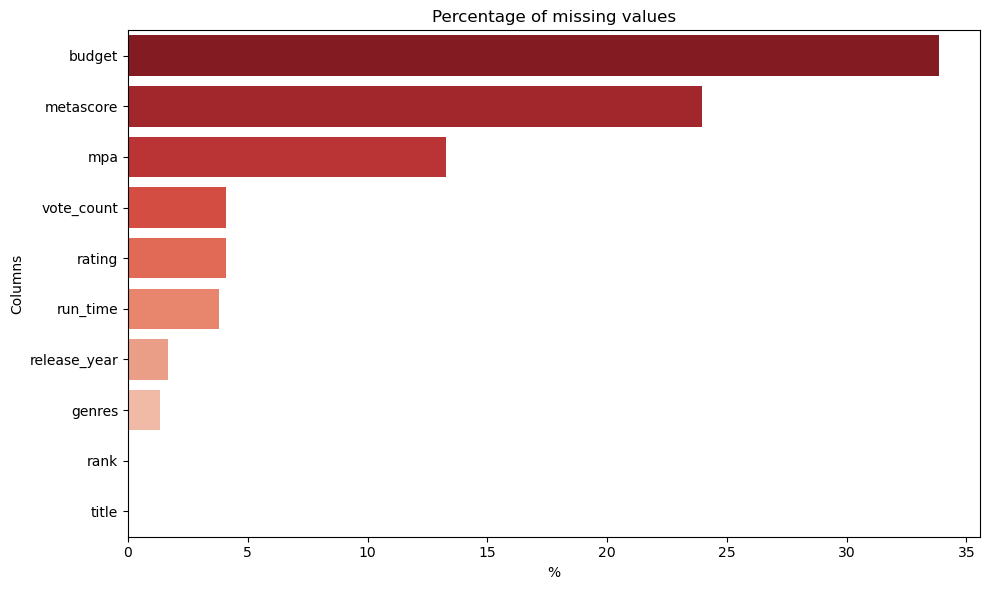

In [36]:
plt.figure(figsize=(10, 6))

sns.barplot(
    x=missing_df['Percentage (%)'], 
    y=missing_df.index,            
    hue=missing_df.index,           
    palette='Reds_r', 
    legend=False
)

plt.title('Percentage of missing values')
plt.xlabel('%')
plt.ylabel('Columns')

plt.tight_layout()
plt.show()

In [37]:
df_clean = df.copy()

Vì đồ án hướng đến bài toán dự đoán điểm `rating`, ở các dòng dữ liệu thiếu giá trị `rating` nhóm quyết định xoá hẳn dòng đó khỏi dataset để khi xây dựng mô hình sẽ không bị sai lệch. 

In [38]:
df_clean = df_clean.dropna(how='any', subset=['rating'], axis=0)

Ở đặc trưng `mpa`, để xử lý missing values nhóm quyết định điền giá trị "Unrated" vì có thể  phim chưa được gửi đi kiểm duyệt hoặc là phim cũ/phim nước ngoài không theo hệ thống MPAA của Mỹ.

In [39]:
df_clean['mpa'] = df_clean['mpa'].fillna('Unrated')

Với `budget` và `metascore`, đây là 2 đặc trưng có tỉ lệ missing values khá cao. `budget` thiếu có thể vì lí do nhà sản xuất không công khai trên nền tảng IMDb, còn `metascore` thiếu có thể do bộ phim không quá nổi tiếng để được các chuyên gia đánh giá. Vì các lí do khách quan như vậy, 2 đặc trưng này nhóm sẽ giữ nguyên và không xử lí. 

Với `release_year` thì nhóm dùng median thay cho mean để điền vào các missing values. Lí do là vì median sẽ tránh cho dữ liệu bị lệch bởi sự ảnh hưởng của các giá trị ngoại lai.

In [40]:
release_year_median = np.nanmedian(df_clean['release_year'])
df_clean['release_year'] = df_clean['release_year'].fillna(release_year_median)

Với `genres` thì nhóm dùng mode để giải quyết missing values vì đây là dữ liệu categorical, không thể tính median.

In [41]:
genres_mode = df_clean['genres'].mode()[0] 
df_clean['genres'] = df_clean['genres'].fillna(genres_mode)

In [42]:
df_clean.to_csv('../data/IMDB_movies_final_cleaned.csv')